### CNN Training on Satellite image dataset
### Ship detection on CNN model

Created: <b>Trong-An Bui</b> <br/>
Advisor: <b>Prof. Pei-Jun Lee</b> <br/>
ViP Lab 116 - EE dept. NCNU

In [1]:
import json, sys, random
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow.keras

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.callbacks

In [4]:
from PIL import Image, ImageDraw 

In [5]:
from matplotlib import pyplot as plt

### Download and study the dataset

In [6]:
# download dataset from json object
f = open(r'./ships-in-satellite-imagery/shipsnet.json') #download at http://vipnas.buitrongan.com:5000/sharing/Gd1gOIi9A
dataset = json.load(f)
f.close()

In [7]:
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

In [8]:
input_data.shape

(4000, 19200)

In [9]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X[0].shape

(3, 80, 80)

In [10]:
# get one chanel
pic = X[0]

rad_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectum = pic[2]

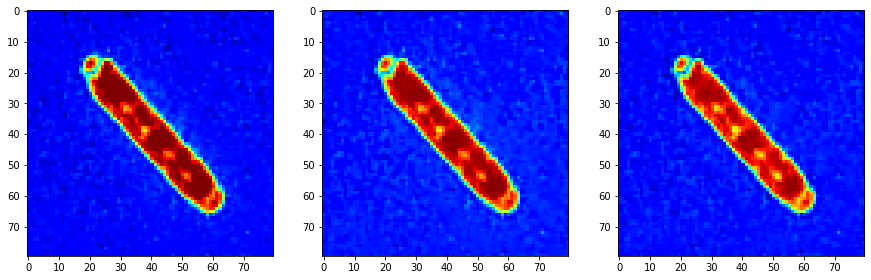

In [11]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# show each channel
plt.subplot(1, 3, 1)
plt.imshow(rad_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectum)
    
plt.show()

In [12]:
output_data.shape

(4000,)

In [13]:
output_data

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [14]:
np.bincount(output_data)

array([3000, 1000])

### Preparing data

In [15]:
# output encoding
y = tensorflow.keras.utils.to_categorical(output_data, 2)

In [16]:
# shuffle all indexes
indexes = np.arange(2800)
np.random.shuffle(indexes)

In [17]:
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [18]:
# normalization
X_train = X_train / 255

### Traing network

In [19]:
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

In [20]:
np.random.seed(42)

In [21]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [22]:
# optimization setup
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Epoch 1/18
70/70 - 1s - loss: 0.3630 - accuracy: 0.8442 - val_loss: 0.1702 - val_accuracy: 0.9482
Epoch 2/18
70/70 - 1s - loss: 0.1489 - accuracy: 0.9513 - val_loss: 0.0901 - val_accuracy: 0.9750
Epoch 3/18
70/70 - 1s - loss: 0.1105 - accuracy: 0.9647 - val_loss: 0.0641 - val_accuracy: 0.9768
Epoch 4/18
70/70 - 1s - loss: 0.0918 - accuracy: 0.9692 - val_loss: 0.0317 - val_accuracy: 0.9946
Epoch 5/18
70/70 - 1s - loss: 0.0879 - accuracy: 0.9705 - val_loss: 0.0381 - val_accuracy: 0.9911
Epoch 6/18
70/70 - 1s - loss: 0.0712 - accuracy: 0.9786 - val_loss: 0.0369 - val_accuracy: 0.9946
Epoch 7/18
70/70 - 1s - loss: 0.0464 - accuracy: 0.9830 - val_loss: 0.0199 - val_accuracy: 0.9964
Epoch 8/18
70/70 - 1s - loss: 0.0482 - accuracy: 0.9844 - val_loss: 0.0223 - val_accuracy: 0.9964
Epoch 9/18
70/70 - 1s - loss: 0.0512 - accuracy: 0.9866 - val_loss: 0.0216 - val_accuracy: 0.9946
Epoch 10/18
70/70 - 1s - loss: 0.0356 - accuracy: 0.9893 - val_loss: 0.0184 - val_accuracy: 0.9946
Epoch 11/18
70/70 -

### Using network

download image

In [25]:
image = Image.open('./ships-in-satellite-imagery/scenes/scenes/sfbay_1.png')
pix = image.load()

In [26]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [27]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [28]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

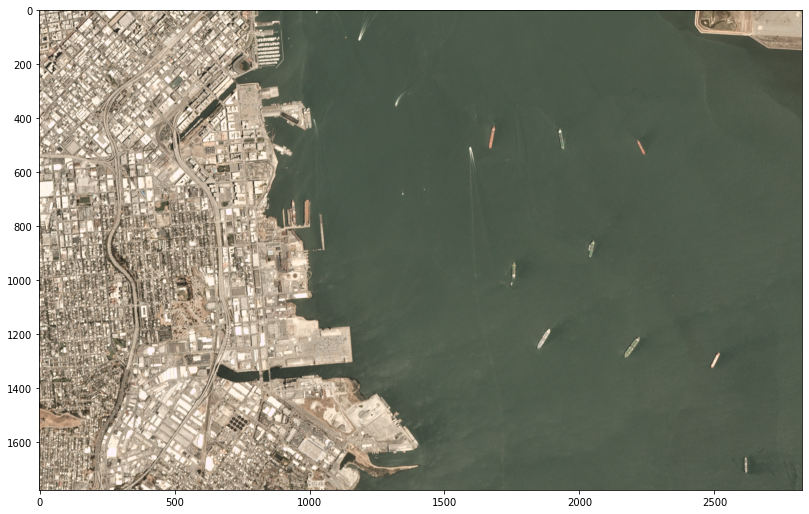

In [29]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [30]:
picture_tensor = picture_tensor.transpose(2,0,1)

Search on the image

In [31]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [32]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [33]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:2400 Y:0  [[0.02159898 0.97840106]]


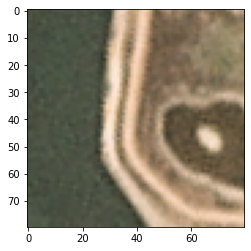

X:2500 Y:40  [[0.06558488 0.9344151 ]]


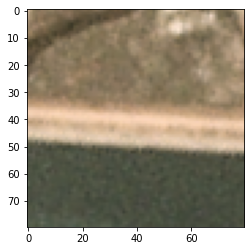

X:1150 Y:50  [[0.05965946 0.9403406 ]]


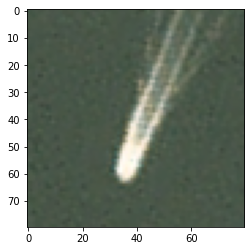

X:820 Y:260  [[0.08463003 0.91537   ]]


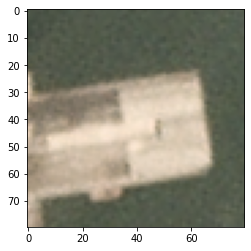

X:1640 Y:410  [[0.01058765 0.98941237]]


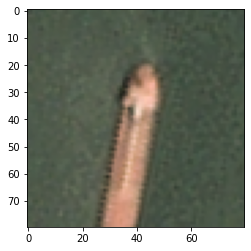

X:1890 Y:420  [[0.00690065 0.99309933]]


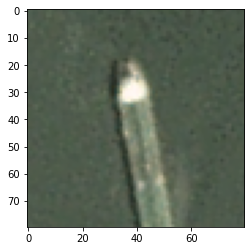

X:2190 Y:460  [[0.09597757 0.90402246]]


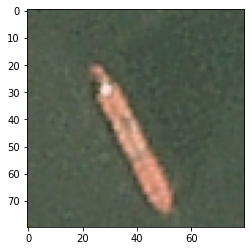

X:850 Y:470   [[0.00738296 0.9926171 ]]


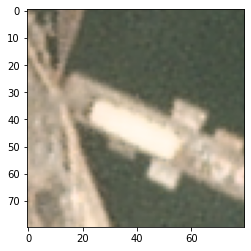

X:950 Y:690  [[0.00398875 0.99601126]]


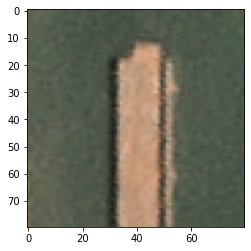

X:1010 Y:780  [[9.669620e-04 9.990331e-01]]


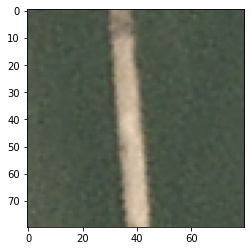

X:2000 Y:850  [[0.09240323 0.9075967 ]]


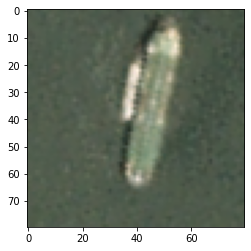

X:1720 Y:920  [[3.1253474e-04 9.9968743e-01]]


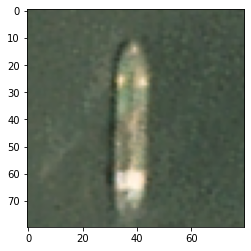

X:1840 Y:1160  [[0.01613698 0.983863  ]]


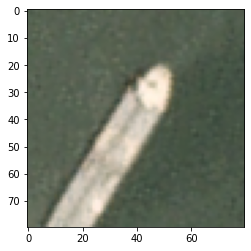

X:2170 Y:1190  [[0.06311145 0.9368886 ]]


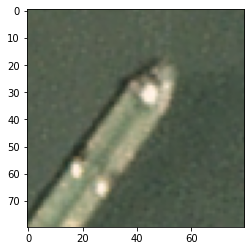

X:2470 Y:1250  [[0.00576478 0.9942352 ]]


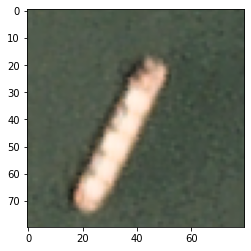

X:2580 Y:1640  [[0.00133569 0.99866426]]


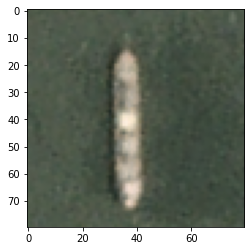

X:1300 Y:1650  [[0.05929129 0.9407087 ]]


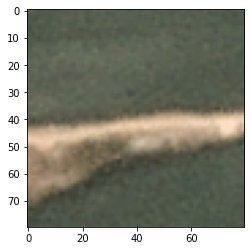

X:2740 Y:1690  

In [34]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [35]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [36]:
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1777, 2825, 3)

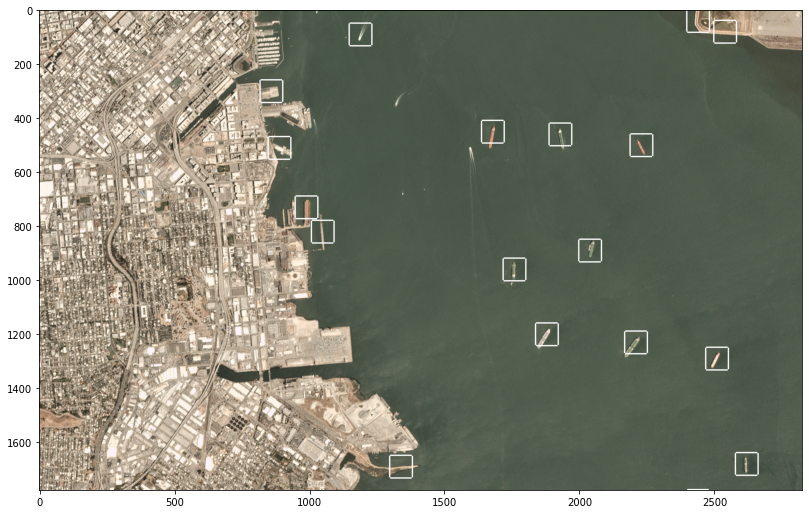

In [37]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()